# This script runs some query statements using ODBC connection and send a formated text by e-mail

In [ ]:
import smtplib
import pypyodbc as pyodbc
import sys
import time
import datetime
from query_check_carga import QUERY_RS, QUERY_SQL # import query statements
from decrypt_password import decrypt_password
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

def execute_query(dsn, query):
    # Try to connect to database using ODBC driver
    try:
        con = pyodbc.connect(dsn)
    except:
        error = sys.exc_info()
        print('[ERROR] Connection failed')
        for e in error:
            print('[ERROR] ' + str(e))
        exit()
    # Try to execute query statement
    try:
        cur = con.cursor()
        cur.execute(query)
        fetch = cur.fetchall()
        return fetch
    except:
        error = sys.exc_info()
        print('[ERROR] Error running query statement!')
        for e in error:
            print('[ERROR] ' + str(e))
        exit()

def send_email(message):
    server = smtplib.SMTP('smtp.gmail.com:587')
    server.ehlo()
    server.starttls()
    server.login('<e-mail_address>@gmail.com', decrypt_password('senha_gmail.bin')) # decrypt_password module to get password
    ts = time.time()
    today_str = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d')
    msg_to = ['<to_e-mail_address_01>', '<to_e-mail_address_01>']
    
    msg = MIMEMultipart('alternative')
    msg['Subject'] = "Check de cargas - " + today_str
    msg['From'] = "<from_e-mail_address>"
    msg['To'] = "<to_e-mail_address>"

    html_msg = """\
    <html>
      <head></head>
      <body>
        <p style="text-align: left;"><span class="im">Ol&aacute;!!!<br /><br />As cargas de hoje, """ + today_str + """, est&atilde;o com as seguintes atualiza&ccedil;&otilde;es: </span></p>
        """ + message + """
      </body>
    </html>
    """

    part2 = MIMEText(html_msg, 'html')
    msg.attach(part2)

    server.sendmail('<from_e-mail_address>', msg_to, msg.as_string())
    server.quit()

odbc_dsn = 'DSN=<ODBC_DSN_01>'
fetch = execute_query(odbc_dsn, QUERY_RS)
check_msg = """
        <table style="height: 60px; width: 510px;" border="#808080">
        <tbody>
        <tr style="height: 1px;">
        <td style="width: 770px; height: 1px; background-color: #009933; text-align: center;" colspan="3"><strong><span style="color: #ffffff;"></span></strong><span style="color: #ffffff;"><strong>Valida&ccedil;&otilde;es</strong></span><span style="color: #ffffff;"><strong></strong></span></td>
        </tr>
        <tr style="height: 1px;">
        <td style="width: 500px; height: 1px; background-color: #009933;"><strong><span style="color: #ffffff;">Tipo</span></strong></td>
        <td style="width: 150px; height: 1px; background-color: #009933;text-align: center;"><span style="color: #ffffff;"><strong>Ano M&ecirc;s</strong></span></td>
        <td style="width: 120px; height: 1px; background-color: #009933;text-align: center;"><span style="color: #ffffff;"><strong>Quantidade</strong></span></td>
        </tr>
        """

for row in fetch:
    row_str = """<tr style="height: 2px;">""" + "\n"
    row_str = row_str + """<td style="width: 500px; height: 2px; background-color: #e6ffee;">""" + str(row[1]) + "\n"
    row_str = row_str + """<td style="width: 150px; height: 2px; background-color: #e6ffee;">""" + str(row[2]) + "\n"
    row_str = row_str + """<td style="width: 120px; height: 2px; text-align: center; background-color: #e6ffee;">""" + str(row[3]) + "\n"
    row_str = row_str + """</tr>""" + "\n"
    check_msg = check_msg + row_str

check_msg = check_msg + """</tbody></table><p></p>""" + "\n"

odbc_dsn = 'DSN=<ODBC_DSN_02>'
fetch = execute_query(odbc_dsn, QUERY_SQL)
check_msg = check_msg + """
        <table style="height: 60px; width: 1000px;" border="#808080">
        <tbody>
        <tr style="height: 1px;">
        <td style="width: 1310px; height: 1px; background-color: #009933; text-align: center;" colspan="4"><strong><span style="color: #ffffff;"></span></strong><span style="color: #ffffff;"><strong>Processos em Execu&ccedil;&atilde;o ou com erro</strong></span><span style="color: #ffffff;"><strong></strong></span></td>
        </tr>
        <tr style="height: 1px;">
        <td style="width: 800px; height: 1px; background-color: #009933;"><strong><span style="color: #ffffff;">Processo</span></strong></td>
        <td style="width: 170px; height: 1px; background-color: #009933;text-align: center;"><span style="color: #ffffff;"><strong>In&iacute;cio</strong></span></td>
        <td style="width: 170px; height: 1px; background-color: #009933;text-align: center;"><span style="color: #ffffff;"><strong>Fim</strong></span></td>
        <td style="width: 170px; height: 1px; background-color: #009933;text-align: center;"><span style="color: #ffffff;"><strong>Status</strong></span></td>
        </tr>
        """

for row in fetch:
    row_str = """<tr style="height: 2px;">""" + "\n"
    if row[2] is None: 
        row_str = row_str + """<td style="width: 800px; height: 2px; background-color: #e6ffee;">""" + str(row[0]) + "\n"
        row_str = row_str + """<td style="width: 170px; height: 2px; background-color: #e6ffee;">""" + str(row[1]) + "\n"
        row_str = row_str + """<td style="width: 170px; height: 2px; text-align: center; background-color: #e6ffee;">""" + "\n"
        row_str = row_str + """<td style="width: 160px; height: 2px; text-align: center; background-color: #e6ffee;">Em Execu&ccedil;&atilde;o""" + "\n"
    else:
        row_str = row_str + """<td style="width: 800px; height: 2px; background-color: #cc0000;color: #ffffff;">""" + str(row[0]) + "\n"
        row_str = row_str + """<td style="width: 170px; height: 2px; background-color: #cc0000;color: #ffffff;">""" + str(row[1]) + "\n"
        row_str = row_str + """<td style="width: 170px; height: 2px; text-align: center; background-color: #cc0000;color: #ffffff;">""" + str(row[2]) + "\n"
        row_str = row_str + """<td style="width: 160px; height: 2px; text-align: center; background-color: #cc0000;color: #ffffff;"><strong>ERRO</strong>""" + "\n"
    row_str = row_str + """</tr>""" + "\n"
    check_msg = check_msg + row_str

check_msg = check_msg + """</tbody></table>""" + "\n"

send_email(check_msg)

# Example of an sent mail

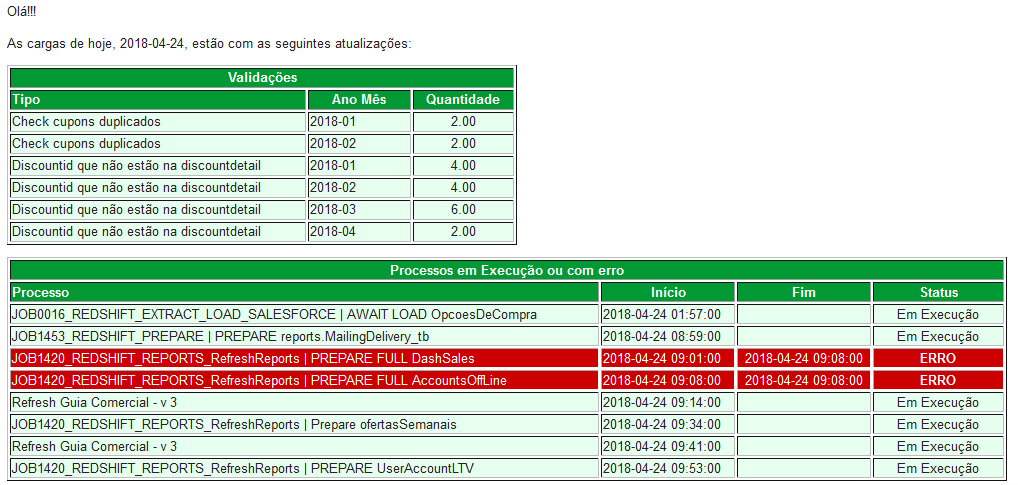